In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM/inferencing")

In [2]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score, auc
from tqdm import tqdm
import pandas as pd
import json, torch

from cover_alpaca2jsonl import format_example

In [3]:
model_path = "THUDM/chatglm2-6b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device = "cuda")
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device_map = "auto")
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map = "auto")
model = torch.compile(model)
model = model.eval()

[2023-07-26 19:34:27,670] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA SETUP: CUDA runtime path found: /xfs/home/tensor_zy/anaconda3/envs/isaacgym/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### Load Dataset

In [4]:
from datasets import load_dataset
import datasets

dataset = load_dataset("piqa")
dataset = dataset['validation']
dataset

Found cached dataset piqa (/xfs/home/tensor_zy/.cache/huggingface/datasets/piqa/plain_text/1.1.0/6c611c1a9bf220943c4174e117d3b660859665baf1d43156230116185312d011)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['goal', 'sol1', 'sol2', 'label'],
    num_rows: 1838
})

In [5]:
dataset = dataset.to_pandas()
dataset['instruction'] = 'Please choose the best answer from the two options.'
dataset['input'] = dataset.apply(lambda x:x['goal'] + " {" + x['sol1']+"/"+x["sol2"]+"}.",axis = 1)
dataset['output'] = dataset.apply(lambda x:x['sol1'] if x['label'] == 0 else x['sol2'], axis = 1)
dataset.head(2)

,goal,sol1,sol2,label,instruction,input,output
0,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Provide the guinea pig with a cage full of a f...,0,Please choose the best answer from the two opt...,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...
1,dresser,replace drawer with bobby pin,"finish, woodgrain with bobby pin",1,Please choose the best answer from the two opt...,dresser {replace drawer with bobby pin /finish...,"finish, woodgrain with bobby pin"


In [6]:
dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")
dataset.head(2)

,goal,sol1,sol2,label,instruction,input,output,context,target
0,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Provide the guinea pig with a cage full of a f...,0,Please choose the best answer from the two opt...,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Instruction: Please choose the best answer fro...,Provide the guinea pig with a cage full of a f...
1,dresser,replace drawer with bobby pin,"finish, woodgrain with bobby pin",1,Please choose the best answer from the two opt...,dresser {replace drawer with bobby pin /finish...,"finish, woodgrain with bobby pin",Instruction: Please choose the best answer fro...,"finish, woodgrain with bobby pin"


In [7]:
context = dataset['context'].tolist()
len(context)

1838

In [8]:
batch_size = 64

total_steps = dataset.shape[0]//batch_size
total_steps

28

In [9]:
res_list = []
res_sentences_list = []
out_text_list = []

for i in tqdm(range(total_steps+1)):
    tmp_context = context[i* batch_size:(i+1)* batch_size]
    tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
    for k in tokens.keys():
        tokens[k] = tokens[k].cuda()
    
    res = model.generate(**tokens, max_length=512)
    res_sentences = [tokenizer.decode(i) for i in res]
    out_text = [o.split("Answer: ")[1] for o in res_sentences]
    res_list += res
    res_sentences_list += res_sentences
    out_text_list += out_text
    torch.cuda.empty_cache()

100%|██████████| 29/29 [08:58<00:00, 18.55s/it]


In [10]:
res_list = [i.cpu() for i in res_list]

In [11]:
dataset["res"] = res_list
dataset["res_sentences"] = res_sentences_list
dataset["out_text"] = out_text_list

In [12]:
out_text_list[:10]

['1.',
 '\n\nOutput: bobby pin / finish, woodgrain',
 '1',
 '1.',
 '1',
 '1.\n\nExplanation: The first option is recommended as it is more likely to remove the soap scum that has formed on the shower door.',
 '1\n\nExplanation: The instructions are similar for both options, but option 1 is the correct one.',
 '1\n\n Output: Press a piece of double-sided tape to the glass jar and then press the toilet paper onto the tape.',
 '1\n\n Output: Find tissue paper and fold it in half. Take scissors and cut out pieces of the paper in the middle. When you are done tape it to your window.',
 '1.\n\nExplanation: Wrap the cord around your hand and elbow is the best way to neatly wrap up an extension cord.']

In [13]:
dataset

,goal,sol1,sol2,label,instruction,input,output,context,target,res,res_sentences,out_text
0,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Provide the guinea pig with a cage full of a f...,0,Please choose the best answer from the two opt...,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Instruction: Please choose the best answer fro...,Provide the guinea pig with a cage full of a f...,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,1.
1,dresser,replace drawer with bobby pin,"finish, woodgrain with bobby pin",1,Please choose the best answer from the two opt...,dresser {replace drawer with bobby pin /finish...,"finish, woodgrain with bobby pin",Instruction: Please choose the best answer fro...,"finish, woodgrain with bobby pin","[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,"\n\nOutput: bobby pin / finish, woodgrain"
2,To fight Ivan Drago in Rocky for sega master s...,Drago isn't in this game because it was releas...,You have to defeat Apollo Creed and Clubber La...,1,Please choose the best answer from the two opt...,To fight Ivan Drago in Rocky for sega master s...,You have to defeat Apollo Creed and Clubber La...,Instruction: Please choose the best answer fro...,You have to defeat Apollo Creed and Clubber La...,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,1
3,Make outdoor pillow.,Blow into tin can and tie with rubber band.,Blow into trash bag and tie with rubber band.,1,Please choose the best answer from the two opt...,Make outdoor pillow. {Blow into tin can and ti...,Blow into trash bag and tie with rubber band.,Instruction: Please choose the best answer fro...,Blow into trash bag and tie with rubber band.,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,1.
4,ice box,will turn into a cooler if you add water to it,will turn into a cooler if you add soda to it,0,Please choose the best answer from the two opt...,ice box {will turn into a cooler if you add wa...,will turn into a cooler if you add water to it,Instruction: Please choose the best answer fro...,will turn into a cooler if you add water to it,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1833,To add chocolate and caramel to hot milk and c...,Chop the chocolate into small chunks. Bring th...,Chop the chocolate into small chunks. Bring th...,1,Please choose the best answer from the two opt...,To add chocolate and caramel to hot milk and c...,Chop the chocolate into small chunks. Bring th...,Instruction: Please choose the best answer fro...,Chop the chocolate into small chunks. Bring th...,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,1\n\nExplanation: The instructions are the sam...
1834,To make orange pulp from oranges.,Peel the oranges and put in blender.,Peel the oranges and use a hand mixer.,0,Please choose the best answer from the two opt...,To make orange pulp from oranges. {Peel the or...,Peel the oranges and put in blender.,Instruction: Please choose the best answer fro...,Peel the oranges and put in blender.,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,1.
1835,Roast marshmallows.,Create a fire using wood. Poke a marshmallow w...,Create a fire using wood. Poke a marshmallow w...,1,Please choose the best answer from the two opt...,Roast marshmallows. {Create a fire using wood....,Create a fire using wood. Poke a marshmallow w...,Instruction: Please choose the best answer fro...,Create a fire using wood. Poke a marshmallow w...,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,

In [14]:
dataset.label.unique()

array([0, 1])

In [26]:
def change_target(x):
    x = str(x)
    if '1' in x: 
        return 0
    elif '2' in x:
        return 1
    else:
        import numpy as np
        return np.nan

<AxesSubplot:>

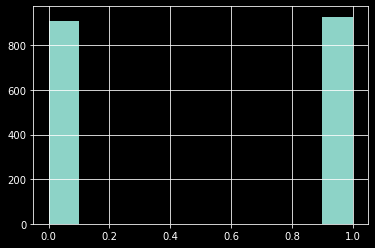

In [17]:
# dataset["new_target"] = dataset["target"].apply(change_target)
dataset["new_target"] = dataset["label"]
dataset["new_target"].hist()

<AxesSubplot:>

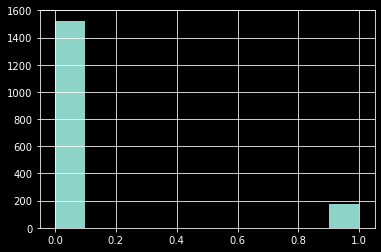

In [27]:
dataset["new_out"] = dataset["out_text"].apply(change_target)
dataset["new_out"].hist()

### 8-bit

In [30]:
dataset["new_out"] = dataset["new_out"].fillna(-1)

In [31]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.49347116430903154

In [32]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.2870312481392829

In [35]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.49347116430903154

In [36]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.42840616148615157

### Full

In [37]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.49347116430903154

In [38]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.2870312481392829

In [39]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.49347116430903154

In [40]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.42840616148615157

In [41]:
dataset.to_csv("fiqa_ori.csv")